# SubspaceDMD
### A minimal tutorial

In this brief tutorial we are going to discuss and experiment the PyDMD implementation of `SubspaceDMD` presented in *Subspace dynamic mode decomposition for stochastic Koopman analysis* ([link](https://journals.aps.org/pre/pdf/10.1103/PhysRevE.96.033310?casa_token=sq-nV4nnEZQAAAAA%3Am4W5ACUZF1zbSa_cCi8y2-f_oSM1har6MHy5sC6zk8g9WGNcqBjWXJ2kLS0Qm2jENAGm5GVjtLym)) by Takeishi et al. We are going to use a very simple toy problem, discussed also in section 4.c in the paper.

The claim provided by the authors in their article is that the proposed variant of the Dynamic Mode Decomposition is able to distinguish the original eigenvalues of a stochastic dynamical system where both process noise and observation noise are present. We clarify the setting with a toy stochastic dynamical system, and verify their claim with some experiments.

First of all we import some dependencies: `NumPy` for numeric thingies, `Matplotlib` for plots. We also import `DMD` from PyDMD, which is going to be used as the baseline for our experiments, as well as `SubspaceDMD`.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({"font.size": 22})

from pydmd import DMD, SubspaceDMD

Our toy (stochastic) dynamical system is defined as follows:
$$
\mathbf{X}_n = \begin{bmatrix}
    r*i & 0\\
    0 & -r*i\\
\end{bmatrix} \mathbf{X}_{n-1} + \mathbf{e}_n \in \mathbb{C}^2
$$

where $i$ denotes the imaginary unit, $r \in \mathbb{R}$ is a user-provided parameter, while $\mathbf{e}_t \in \mathbb{C}^2$ is called *process noise*. We assume $\mathbf{e}_t$ to be gaussian white noise, which we implement as follows:

In [2]:
def complex_gaussian_noise(components, n, scale):
    noise = np.random.normal(
        loc=0, scale=np.sqrt(2 * scale) / 2, size=(n * components, 2)
    ).view(np.complex128)
    return noise.reshape((components, n))


print(np.var(complex_gaussian_noise(3, 10000000, scale=0.3), axis=1))
print(np.abs(np.mean(complex_gaussian_noise(3, 10000000, scale=0.3), axis=1)))

[0.30004867 0.29998452 0.29997961]
[6.16696562e-05 2.17204920e-04 1.13484050e-04]


As you can see the basic properties of the Gaussian distribution are satisfied. We now implement the system above, and provide also two very simple instances for $r=0.9$ (damped) and $r=1$ (oscillator):

In [3]:
def linear_time_invariant_system(r, process_noise_scale, T, cmp, X0):
    lmbd = complex(0, r)

    X = np.empty((cmp, T), dtype=np.complex128)
    X[:, 0] = X0

    noise = complex_gaussian_noise(cmp, T - 1, process_noise_scale)
    mul = np.array([[lmbd, 0], [0, np.conj(lmbd)]])
    for i in range(1, T):
        X[:, i] = mul.dot(X[:, i - 1]) + noise[:, i - 1]
    return X


def oscillator(process_noise_scale, T=1000, X0=np.array([1, 1])):
    return linear_time_invariant_system(
        r=1, process_noise_scale=process_noise_scale, T=T, cmp=2, X0=X0
    )


def damped(process_noise_scale, T=1000, X0=np.array([1, 1])):
    return linear_time_invariant_system(
        r=0.9, process_noise_scale=process_noise_scale, T=T, cmp=2, X0=X0
    )

We visualize the two instances in the plots below, setting the scale of the process noise (i.e. the standard deviation of the gaussian noise) to `0.1`:

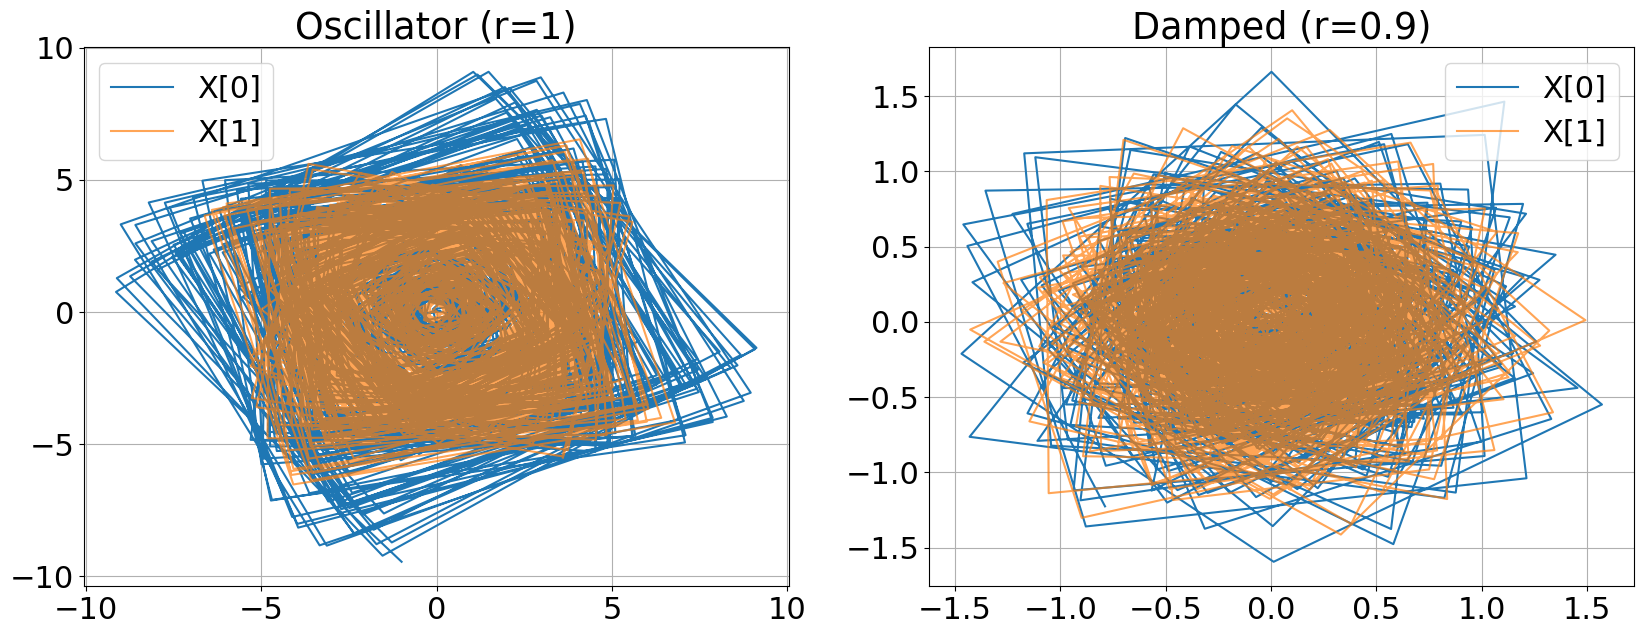

In [4]:
proc_noise = 0.1

plt.figure(figsize=(20, 7))

plt.subplot(1, 2, 1)
X_oscillator = oscillator(proc_noise)

plt.plot(X_oscillator.real[0], X_oscillator.imag[0], label="X[0]")
plt.plot(X_oscillator.real[1], X_oscillator.imag[1], label="X[1]", alpha=0.7)

plt.legend()
plt.grid()
plt.title("Oscillator (r=1)")

plt.subplot(1, 2, 2)
X_damped = damped(proc_noise)

plt.plot(X_damped.real[0], X_damped.imag[0], label="X[0]")
plt.plot(X_damped.real[1], X_damped.imag[1], label="X[1]", alpha=0.7)

plt.legend()
plt.grid()
plt.title("Damped (r=0.9)")

plt.show()

We now procede with the definition of the *observed* system:
$$
\mathbf{Y}_n = \mathbf{X}_n + \mathbf{w}_n \in \mathbb{C}^2
$$
where again $\mathbf{w}_n \in \mathbb{C}^2$ is gaussian white noise which we call *observation noise*.

We visualize the same instances generated above, in their *observed* counterparts, setting the scale of the observation noise to `0.1`:

In [5]:
def observe(X, observation_noise_scale):
    return X + complex_gaussian_noise(*X.shape, observation_noise_scale)

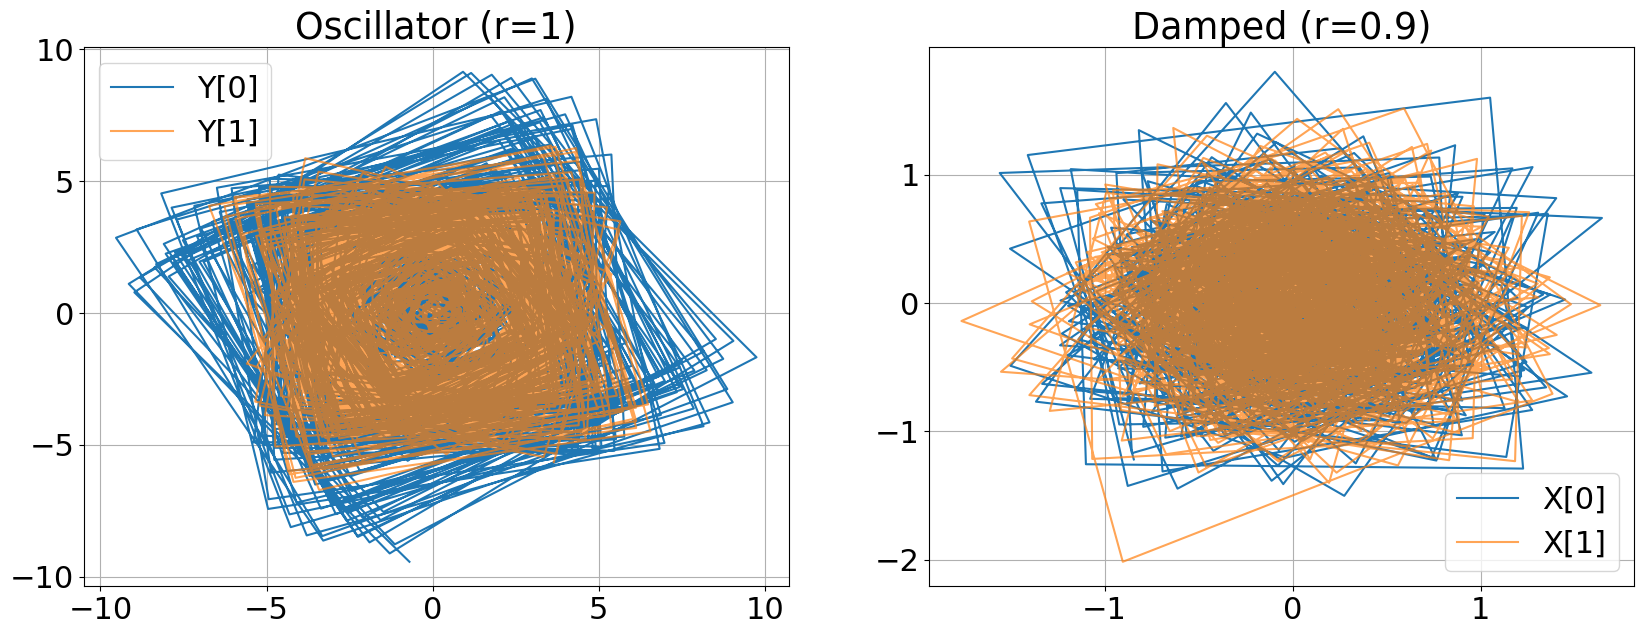

In [6]:
obs_noise = 0.1

plt.figure(figsize=(20, 7))

plt.subplot(1, 2, 1)
Y_oscillator = observe(X_oscillator, obs_noise)

plt.plot(Y_oscillator.real[0], Y_oscillator.imag[0], label="Y[0]")
plt.plot(Y_oscillator.real[1], Y_oscillator.imag[1], label="Y[1]", alpha=0.7)

plt.legend()
plt.grid()
plt.title("Oscillator (r=1)")

plt.subplot(1, 2, 2)
Y_damped = observe(X_damped, obs_noise)

plt.plot(Y_damped.real[0], Y_damped.imag[0], label="X[0]")
plt.plot(Y_damped.real[1], Y_damped.imag[1], label="X[1]", alpha=0.7)

plt.legend()
plt.grid()
plt.title("Damped (r=0.9)")

plt.show()

As you can see the system is quite more irregular in its observed version, due to the additional uncertainty added by the observation noise. One of the most important features of DMD is its ability to extract important eigenvalues from the dynamic of the system, which then can be used to predict the evolution of the system even in unseen time instants with some degree degree of approximation. For more details on this check *Dynamic mode decomposition: data-driven modeling of complex systems* by Kutz et al.

For this reason being able to extract the appropriate eigenvalues from the system is a key aspect of the method, and the claim stated by the authors of *Subspace dynamic mode decomposition for stochastic Koopman analysis* is that `SubspaceDMD` is able to do so even in presence of observation noise. This means that their variant should be able to *ignore* in some sense the observation noise, and deliver the eigenvalues found on the same system without any observation noise.

We're going to verify this claim in several settings with some experiments. First of all we define `evaluate_eigs` (which fits a DMD instance and returns the eigenvalues extracted) and `plot_eigs` (plots a set of eigenvalues).

In [7]:
def evaluate_eigs(dmd, X):
    return dmd.fit(X).eigs


def plot_eigs(*args):
    plt.figure(figsize=(20, 7))
    for eigs, label in args:
        plt.plot(eigs.real, eigs.imag, "o", label=label)

    plt.grid()
    plt.legend()

    plt.xlabel("Real")
    plt.xlabel("Imaginary")

    plt.show()

Then we define a function called `do_experiment` which expects in input the parameter `r` (which controls the damping of the system) the process and observation noise `pnoise` and `onoise`, the number of time instants simulated `T`. `do_experiment` computes the eigenvalues extracted:
- by `DMD` from the system with no observation noise;
- by `DMD` from the system with observation noise;
- by `SubspaceDMD` from the system with observation noise.

`do_experiment` allows also passing an optional parameter `action` which lets the user specify an action to perform with the eigenvalues extracted. By default this is set to `plot_eigs` defined above.

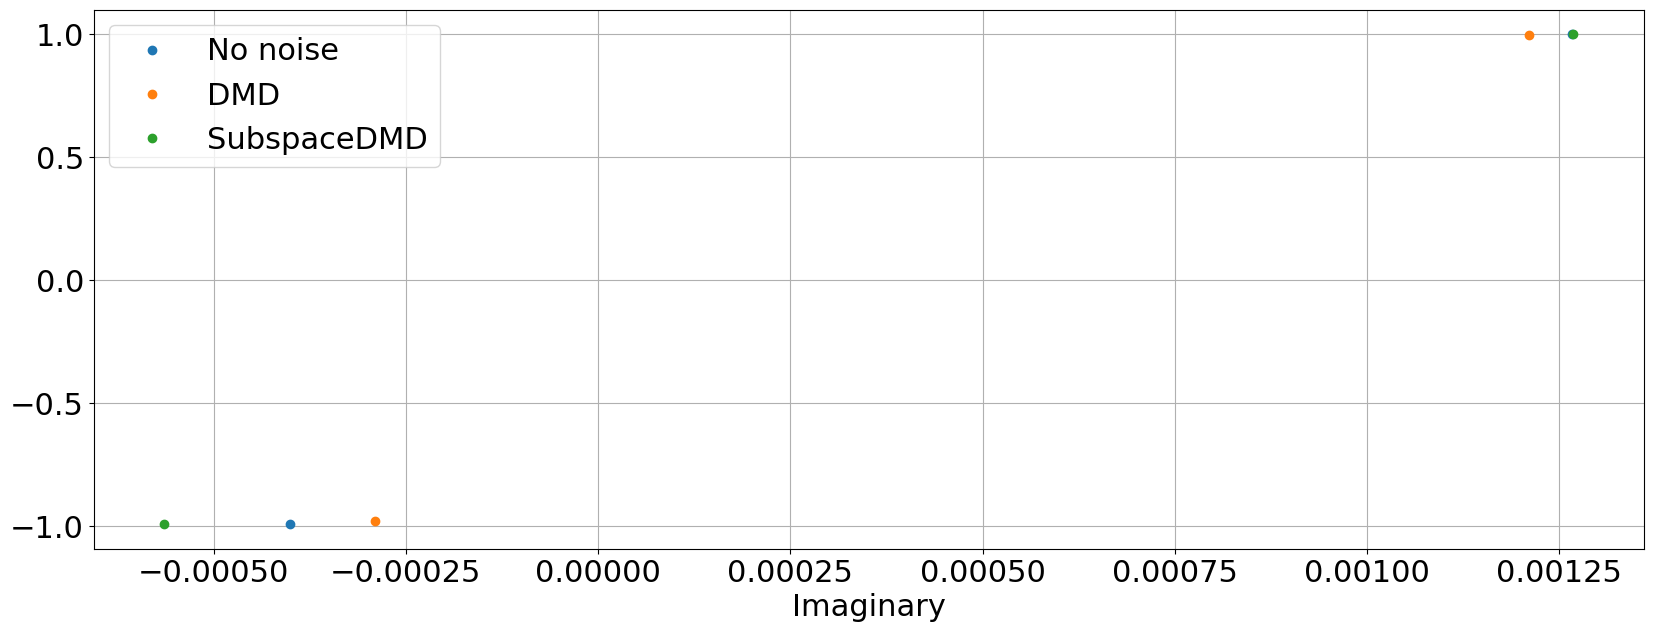

In [8]:
def do_experiment(r, pnoise, onoise, T=1000, action=plot_eigs):
    X = linear_time_invariant_system(
        r, process_noise_scale=pnoise, T=T, cmp=2, X0=np.array([1, 1])
    )
    Y = observe(X, onoise)

    # no noise
    dmd_nonoise = evaluate_eigs(DMD(svd_rank=-1, sorted_eigs="real"), X)

    dmd = evaluate_eigs(DMD(svd_rank=-1, sorted_eigs="real"), Y)
    sdmd = evaluate_eigs(SubspaceDMD(svd_rank=-1, sorted_eigs="real"), Y)

    return action(
        (dmd_nonoise, "No noise"), (dmd, "DMD"), (sdmd, "SubspaceDMD")
    )


do_experiment(1, 0.1, 0.1)

We define another action which computes the distance between the following pairs of eigenvalues:
- `DMD`, no observation noise VS `DMD` with observation noise
- `DMD`, no observation noise VS `SubspaceDMD` with observation noise

Note that in `compute_distance` we use NumPy broadcasting to compute all the possible pairwise distances among the eigenvalues since we are not sure about which pairs of eigenvalues from two different lists should be paired. We then choose the set of pairs which minimizes the sum of distances.

The distance among pairs of eigenvalues is computed using the *relative error* formula, used also in the original paper:
$$
\text{err} = \frac{|\lambda - \tilde{\lambda}|}{|\lambda|}
$$

where $\lambda$ denotes the eigenvalue in the system without observation noise (extracted using `DMD`), and $\tilde{\lambda}$ denotes the eigenvalue extracted from the system with observation noise using either `DMD` or `SubspaceDMD`.

In [9]:
def compute_distance(*args):
    no_noise, _ = args[0]
    dmd, _ = args[1]
    sdmd, _ = args[2]

    dmd_dst = np.abs(dmd[None] - no_noise[:, None]) / np.abs(no_noise[:, None])
    sdmd_dst = np.abs(sdmd[None] - no_noise[:, None]) / np.abs(
        no_noise[:, None]
    )

    return np.sum(np.min(dmd_dst, axis=0)), np.sum(np.min(sdmd_dst, axis=0))


do_experiment(1, 0.1, 0.1, action=compute_distance)

(0.003930811686504048, 0.00012970081239536748)

<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Meu Computador\AppData\Local\Temp\ipykernel_932\2278919520.py:29: SyntaxWarning: invalid escape sequence '\s'
  plt.title("$\sigma_p = 0.1, \sigma_o = 0.1$")


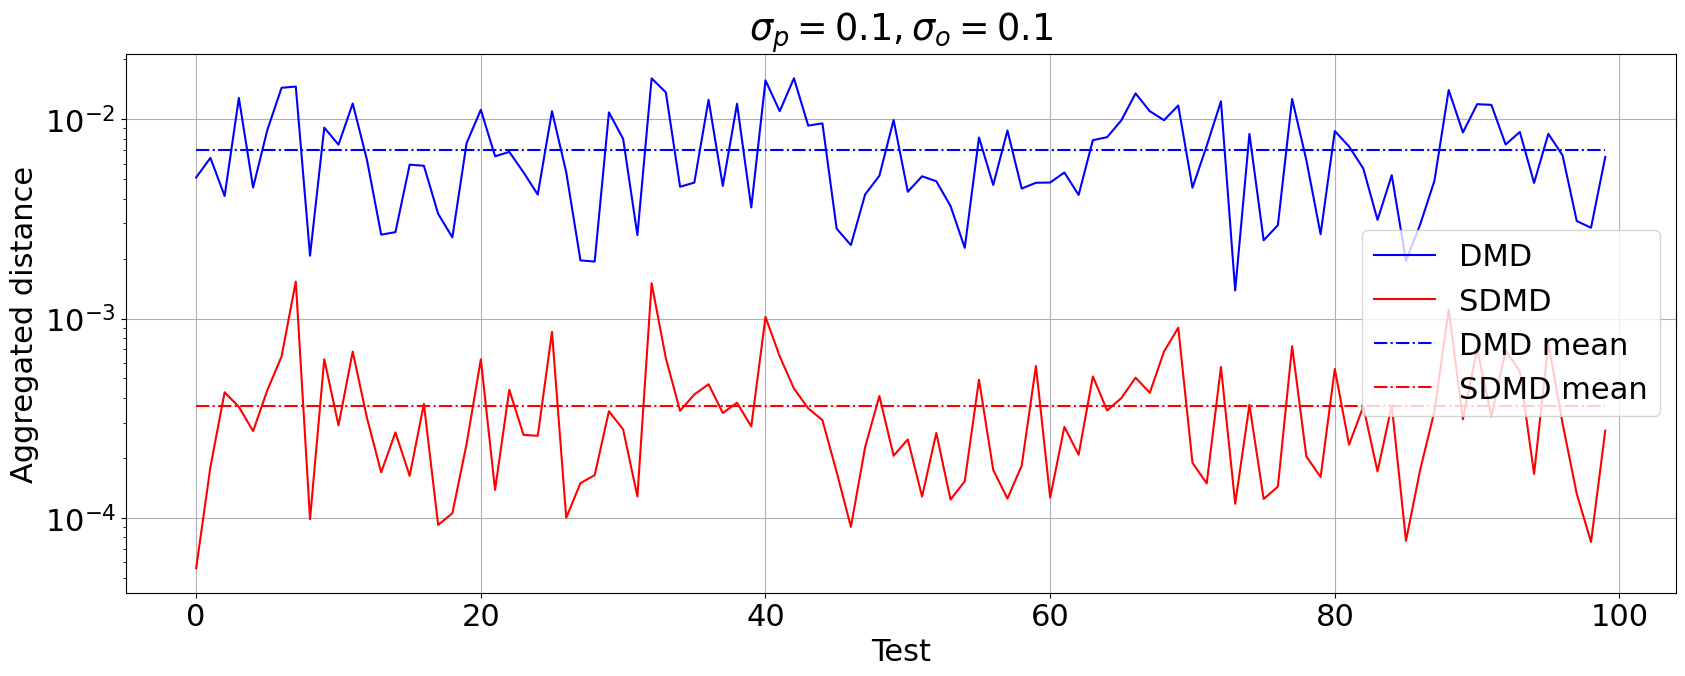

In [10]:
times = 100

data = np.array(
    [do_experiment(1, 0.1, 0.1, action=compute_distance) for _ in range(times)]
)

plt.figure(figsize=(20, 7))
plt.plot(data[:, 0], "b", label="DMD")
plt.plot(data[:, 1], "r", label="SDMD")

plt.plot(
    range(times), np.repeat(np.mean(data[:, 0]), times), "-.b", label="DMD mean"
)
plt.plot(
    range(times),
    np.repeat(np.mean(data[:, 1]), times),
    "-.r",
    label="SDMD mean",
)

plt.yscale("log")

plt.grid()
plt.legend()

plt.xlabel("Test")
plt.ylabel("Aggregated distance")

plt.title("$\sigma_p = 0.1, \sigma_o = 0.1$")

plt.show()

Here by *aggregated distance* (y axis) we mean the sum of the distances (which we adopt as our error metric) from eigenvalues extracted **without** observation noise and those extracted **with** observation noise, using either `DMD` or `SubspaceDMD`. As you can see clearly `SubspaceDMD` is able to find much better the original eigenvalues, therefore the claim is verified.

## Sensitivity to $\sigma_o$ (observation noise)
We now test briefly how the mean error (i.e. aggregated distances between pairs of corresponding eigenvalues) react as the observation noise increases (in the plot above it was fixed to $\sigma_o = 0.1$). We keep $\sigma_o$ fixed to `0.1`, and $r=1$.

In [11]:
def extract_means(r, pnoise, onoise, times, T=1000):
    data = np.array(
        [
            do_experiment(
                r=1, pnoise=pnoise, onoise=onoise, T=T, action=compute_distance
            )
            for _ in range(times)
        ]
    )
    return np.mean(data, axis=0)

<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Meu Computador\AppData\Local\Temp\ipykernel_932\927558320.py:16: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel("$\sigma_o$")
C:\Users\Meu Computador\AppData\Local\Temp\ipykernel_932\927558320.py:19: SyntaxWarning: invalid escape sequence '\s'
  plt.title("$\sigma_p = 0.1$")


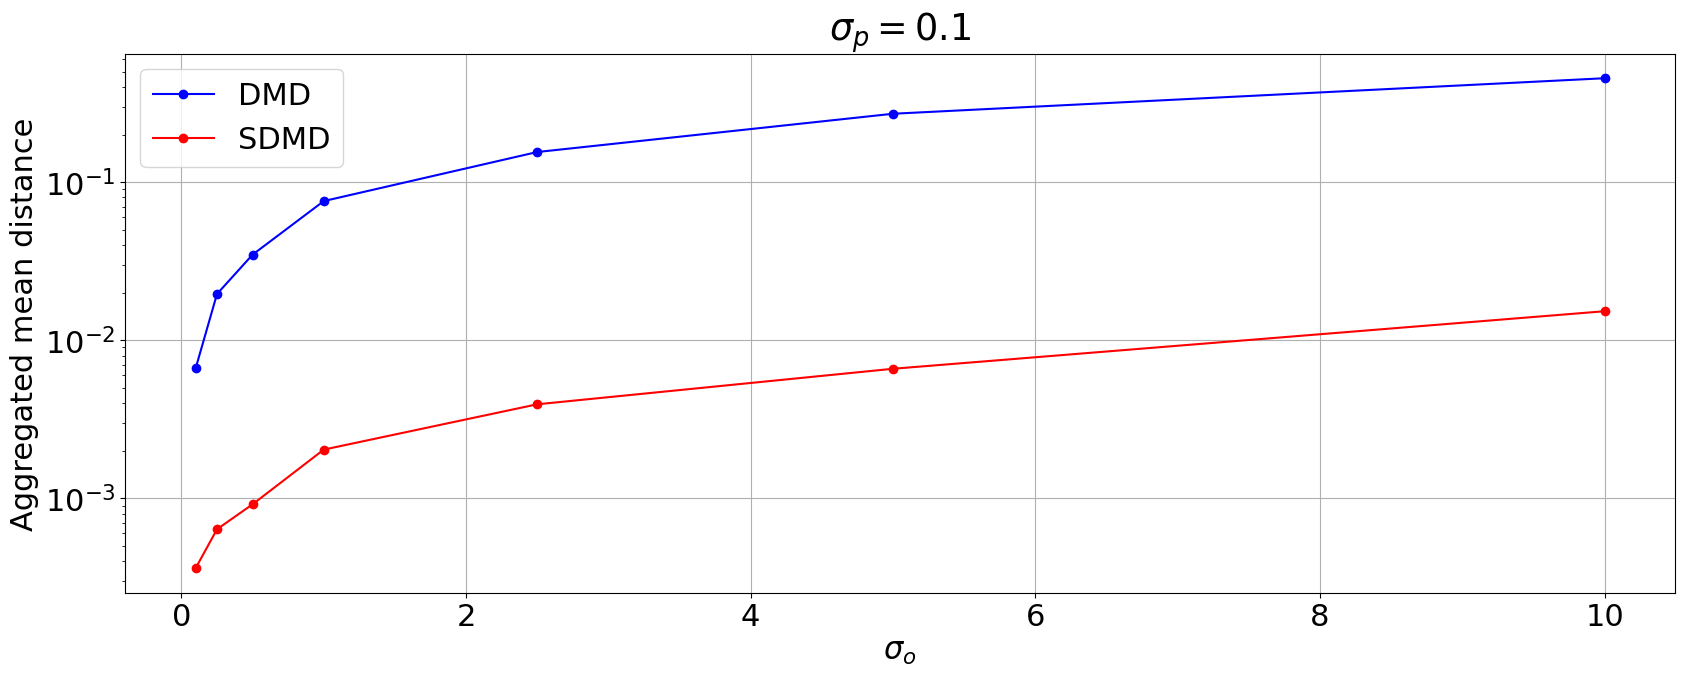

In [12]:
onoise_grid = [0.1, 0.25, 0.5, 1, 2.5, 5, 10]

data = np.array(
    [extract_means(1, 0.1, onoise, times) for onoise in onoise_grid]
)

plt.figure(figsize=(20, 7))
plt.plot(onoise_grid, data[:, 0], "-ob", label="DMD")
plt.plot(onoise_grid, data[:, 1], "-or", label="SDMD")

plt.yscale("log")

plt.grid()
plt.legend()

plt.xlabel("$\sigma_o$")
plt.ylabel("Aggregated mean distance")

plt.title("$\sigma_p = 0.1$")

plt.show()

In the plot above it's very clear that process noise in fact damages the accuracy of both `SubspaceDMD` and `DMD`. However since the plot is logarithmic we conclude that in this case:
1. `SubspaceDMD` delivers results on average 1 order of magnitude more accurate than `DMD`;
2. The accuracy of `SubspaceDMD` worsen slower than the accuracy of `DMD` as we increase $\sigma_o$.

## Sensitivity to $\sigma_p$ (process noise)
As above, we investigate the dependency of the method accuracy for finding the eigenvalues when the process noise is increased. $\sigma_o$ is fixed to `0.1` now, while $r$ remains `1`.

<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Meu Computador\AppData\Local\Temp\ipykernel_932\189923188.py:16: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel("$\sigma_p$")
C:\Users\Meu Computador\AppData\Local\Temp\ipykernel_932\189923188.py:19: SyntaxWarning: invalid escape sequence '\s'
  plt.title("$\sigma_o = 0.1$")


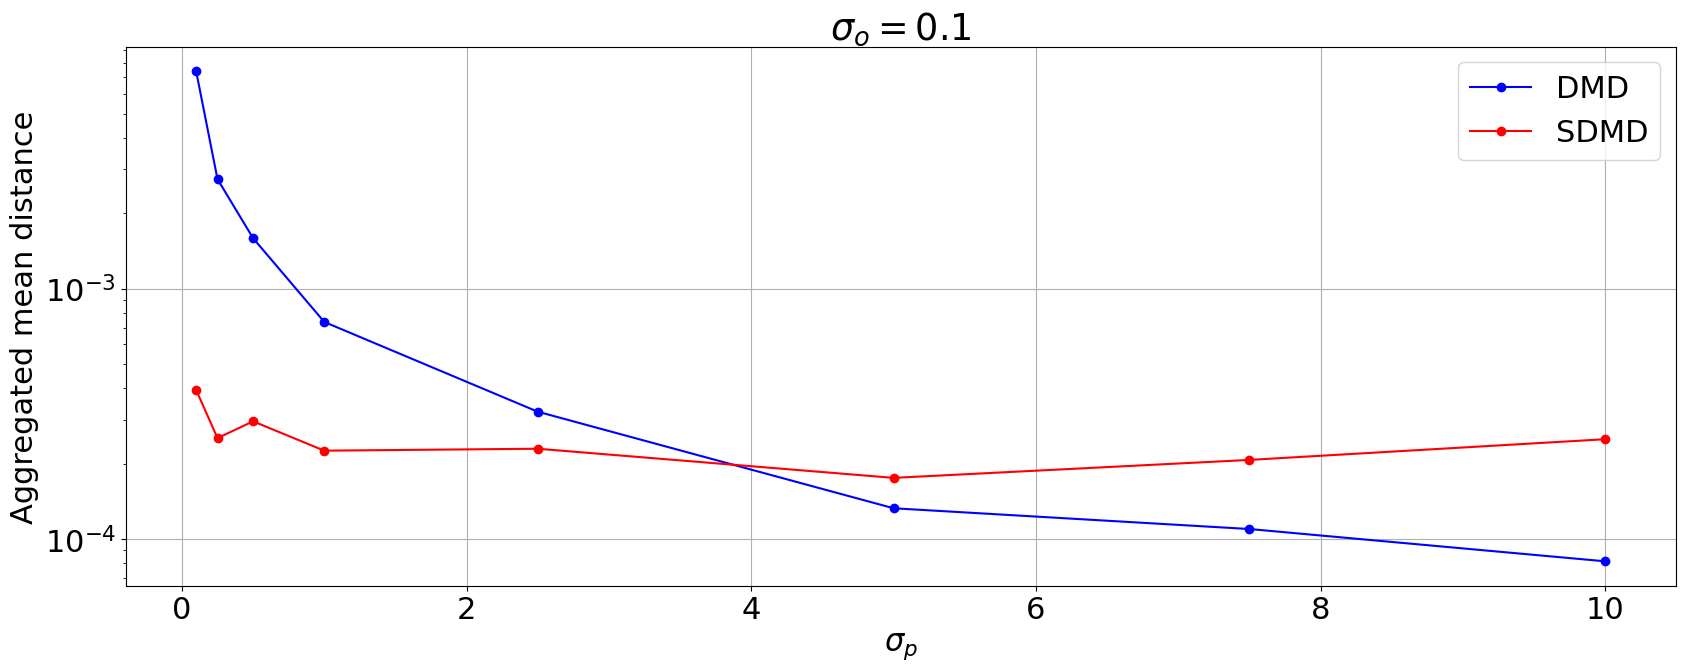

In [13]:
pnoise_grid = [0.1, 0.25, 0.5, 1, 2.5, 5, 7.5, 10]

data = np.array(
    [extract_means(1, pnoise, 0.1, times) for pnoise in pnoise_grid]
)

plt.figure(figsize=(20, 7))
plt.plot(pnoise_grid, data[:, 0], "-ob", label="DMD")
plt.plot(pnoise_grid, data[:, 1], "-or", label="SDMD")

plt.yscale("log")

plt.grid()
plt.legend()

plt.xlabel("$\sigma_p$")
plt.ylabel("Aggregated mean distance")

plt.title("$\sigma_o = 0.1$")

plt.show()

In this case something interesting happens: as we raise $\sigma_p$ `SubspaceDMD` provides approximately results on the same quality. However `DMD` improves drastically and overcomes `SubspaceDMD` in terms of accuracy of eigenvalues location. We conclude that in presence of strong noise scattered on a significant width the method proposed by the authors is not the best one for this application among all DMD variants.

## Sensitivity to `r` (damping parameter)
In the first part of this notebook we stated that $r=1$ yields a kind-of obscillator, while $r=0.9$ yields a damped dynamical system. We now perform a more general analysis for various values of $r$, and check what happens to the accuracy of `SubspaceDMD`. In this case we fix $\sigma_o=\sigma_p=0.1$.

<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Meu Computador\AppData\Local\Temp\ipykernel_932\3105407012.py:17: SyntaxWarning: invalid escape sequence '\s'
  plt.title("$\sigma_p = 0.1, sigma_o = 0.1$")


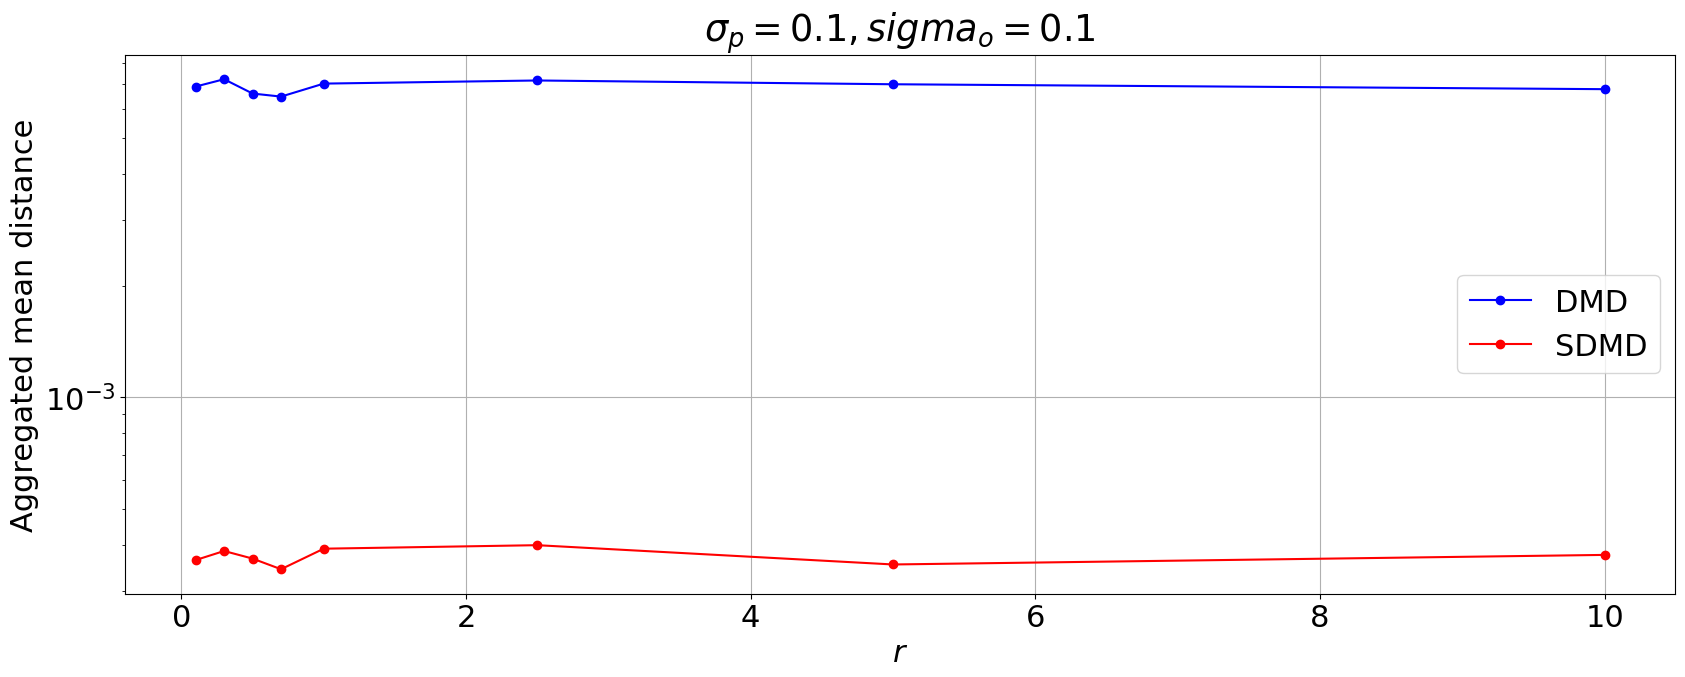

In [14]:
r_grid = [0.1, 0.3, 0.5, 0.7, 1, 2.5, 5, 10]

data = np.array([extract_means(ri, 0.1, 0.1, times) for ri in r_grid])

plt.figure(figsize=(20, 7))
plt.plot(r_grid, data[:, 0], "-ob", label="DMD")
plt.plot(r_grid, data[:, 1], "-or", label="SDMD")

plt.yscale("log")

plt.grid()
plt.legend()

plt.xlabel("$r$")
plt.ylabel("Aggregated mean distance")

plt.title("$\sigma_p = 0.1, sigma_o = 0.1$")

plt.show()

It's very clear from the plot that the quality of results provided by both `DMD` and `SubspaceDMD` are pretty much independent of the value of the damping parameter `r`.

## Sensitivity to the dimensionality of the data
The last experiment we conceived consists in investigating the change in quality consequent to the change of dimensionality in the data. Until now we considered matrices sized `2x1000`. Usually the dimensionality of the space is much greater than 2 (DMD is usually I applied in CFD contexts, therefore the number of dimensions is the value of the pressure and of the velocity of the fluid in the whole (discretized) space to be considered, in all the dimensions (1, 2 or 3 usually).

In order to perform the experiment we define a new system as follows:
$$
\mathbf{Y}^2_N = \begin{bmatrix}
e^{a_0 \mathbf{X}_N}\\
e^{a_1 \mathbf{X}_N}\\
\vdots\\
e^{a_{k-1} \mathbf{X}_N}\\
e^{a_{k} \mathbf{X}_N}
\end{bmatrix} + \mathbf{w}_N
$$

where $a_0, \dots, a_k$ is a set of pre-defined multipliers, and $\mathbf{w}_N$ is gaussian white noise. Since $X_N \in \mathbb{C}^{2 \times T}$ the shape of the new system is $2*k \times T$.

In [15]:
def observe2(X, k, observation_noise_scale):
    a = np.linspace(0.1, 10, k)
    return observe(
        np.exp((a[:, None, None] * X[None]).reshape(-1, X.shape[1])),
        observation_noise_scale,
    )

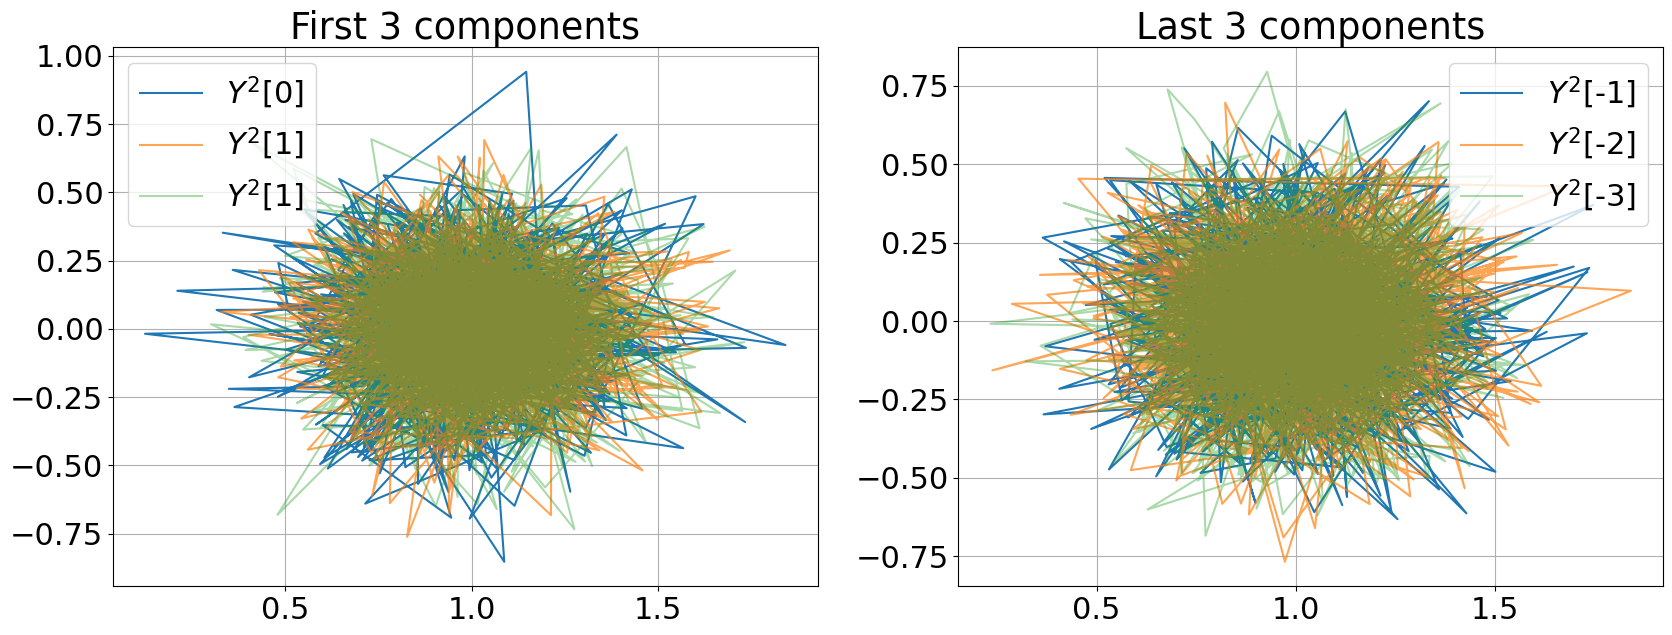

In [16]:
obs_noise = 0.1

plt.figure(figsize=(20, 7))

plt.subplot(1, 2, 1)
Y2 = observe2(X_damped / 100, 500, obs_noise)

plt.plot(Y2.real[0], Y2.imag[0], label="$Y^2$[0]")
plt.plot(Y2.real[1], Y2.imag[1], label="$Y^2$[1]", alpha=0.7)
plt.plot(Y2.real[2], Y2.imag[2], label="$Y^2$[1]", alpha=0.4)

plt.legend()
plt.grid()
plt.title("First 3 components")

plt.subplot(1, 2, 2)

plt.plot(Y2.real[-1], Y2.imag[-1], label="$Y^2$[-1]")
plt.plot(Y2.real[-2], Y2.imag[-2], label="$Y^2$[-2]", alpha=0.7)
plt.plot(Y2.real[-3], Y2.imag[-3], label="$Y^2$[-3]", alpha=0.4)

plt.legend()
plt.grid()
plt.title("Last 3 components")

plt.show()

Note that we scaled down the original system $X$ by 10 in order to avoid blow-up due to the exponential. We now turn to eigenvalues, and consider varying systems for multiple choices of $k$ (number of multiplier in $a$). As before, we define some utility functions:

C:\Users\Meu Computador\AppData\Roaming\Python\Python312\site-packages\pydmd\snapshots.py:73: UserWarning: Input data condition number 10853921.973218553. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


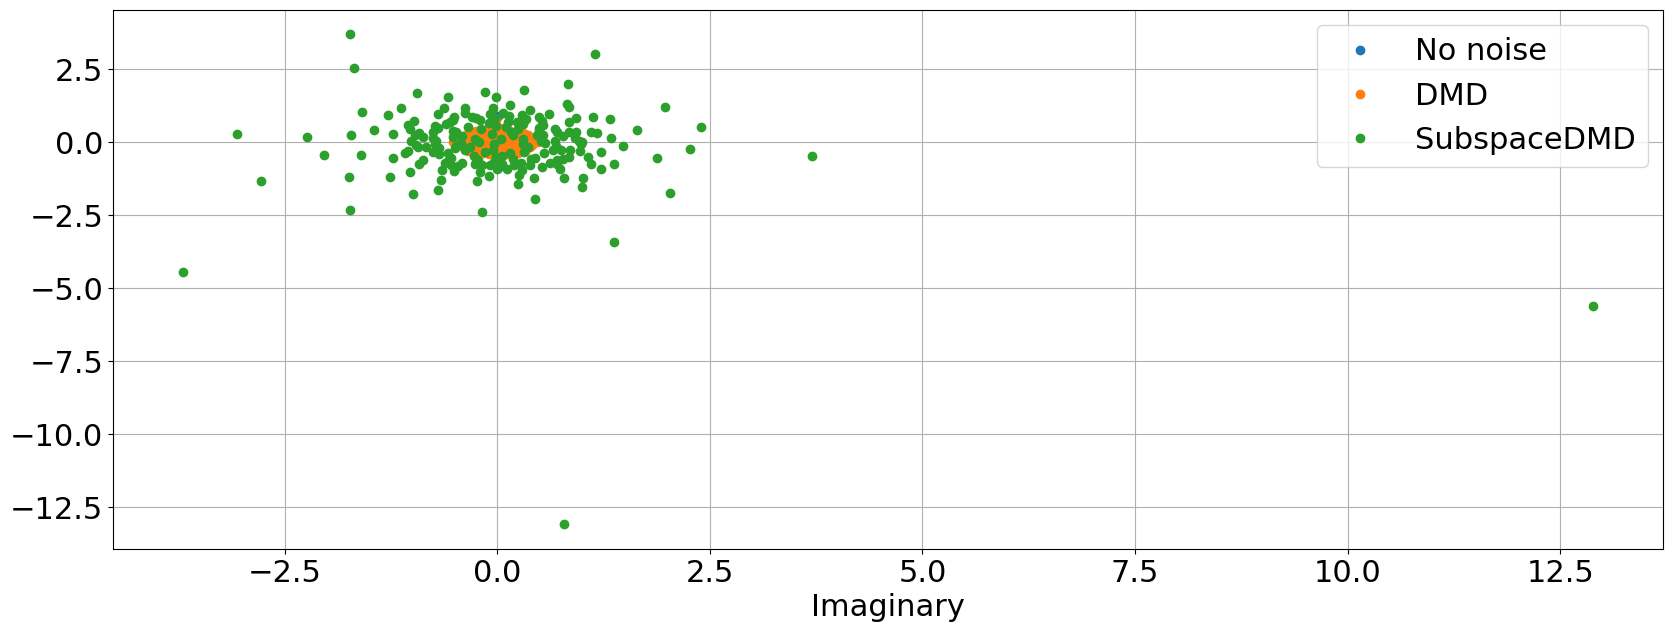

In [17]:
def do_experiment2(r, pnoise, onoise, k, T=1000, action=plot_eigs):
    X = linear_time_invariant_system(
        r, process_noise_scale=pnoise, T=T, cmp=2, X0=np.array([1, 1])
    )
    Y = observe2(X, k, onoise)

    # no noise
    dmd_nonoise = evaluate_eigs(DMD(svd_rank=-1, sorted_eigs="real"), X)

    dmd = evaluate_eigs(DMD(svd_rank=-1, sorted_eigs="real"), Y)
    sdmd = evaluate_eigs(SubspaceDMD(svd_rank=-1, sorted_eigs="real"), Y)

    return action(
        (dmd_nonoise, "No noise"), (dmd, "DMD"), (sdmd, "SubspaceDMD")
    )


def extract_means2(r, pnoise, onoise, k, times, T=1000):
    data = np.array(
        [
            do_experiment2(
                r=1,
                pnoise=pnoise,
                onoise=onoise,
                k=k,
                T=T,
                action=compute_distance,
            )
            for _ in range(times)
        ]
    )
    return np.mean(data, axis=0)


do_experiment2(0.9, 0.1, 0.1, 100)

If you execute the cell code above you're probably receiving a warning by PyDMD, due to the fact that the matrix we provided is strongly ill-conditioned. This is not a good setting for DMD, since low rank matrices are difficult to treat numerically due to the instability of numerical methods like SVD.

<>:23: SyntaxWarning: invalid escape sequence '\s'
<>:23: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Meu Computador\AppData\Local\Temp\ipykernel_932\2401308877.py:23: SyntaxWarning: invalid escape sequence '\s'
  plt.title("$\sigma_p = 0.1, sigma_o = 0.1, r=0.9$")


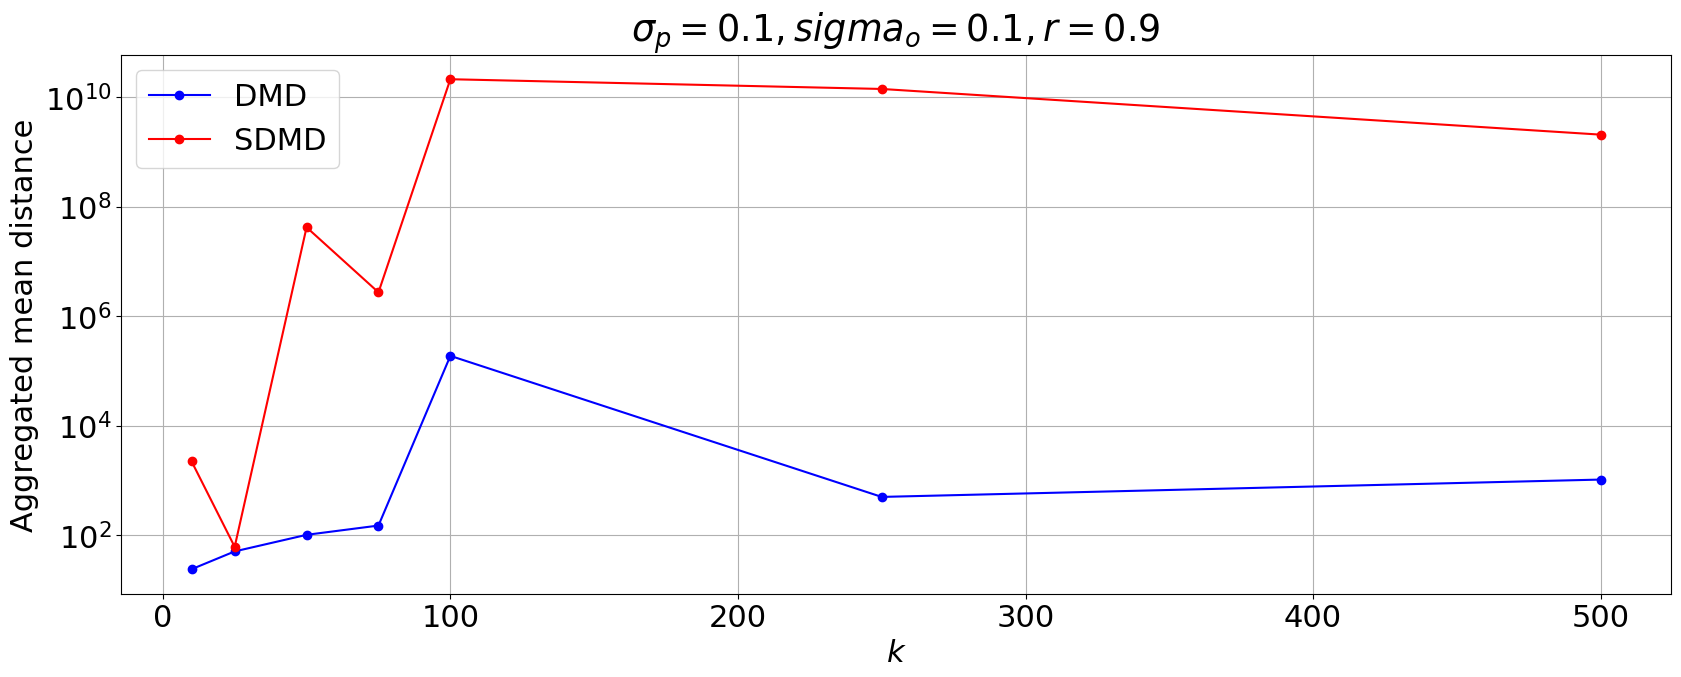

In [18]:
import warnings

warnings.filterwarnings("ignore")

k_grid = [10, 25, 50, 75, 100, 250, 500]

data = np.array(
    [extract_means2(0.9, 0.1, 0.1, k=ki, times=10) for ki in k_grid]
)

plt.figure(figsize=(20, 7))
plt.plot(k_grid, data[:, 0], "-ob", label="DMD")
plt.plot(k_grid, data[:, 1], "-or", label="SDMD")

plt.yscale("log")

plt.grid()
plt.legend()

plt.xlabel("$k$")
plt.ylabel("Aggregated mean distance")

plt.title("$\sigma_p = 0.1, sigma_o = 0.1, r=0.9$")

plt.show()

There are two important things to notice here:
1. We set `times=10` to make this experiment more computationally viable. However this is clearly not enough to obtain a strong statistic on the quality of the results;
2. The errors here exploded (the mean error for `SubspaceDMD` reaches even $10^9$). 

We briefly motivate (2). Such bad results happened because, as we mentioned before, there are only 2 important modes in the matrix we provided. This means that we have a lot of marginally interesting eigenvalues, which are scattered around the point $(0,0)$. We recall the formula we are using to compute the error:
$$
\text{err} = \frac{|\lambda - \tilde{\lambda}|}{|\lambda|}
$$

If $\lambda$ is very small in module, any small error is going to be amplified. This, combined with the fact that DMD in general works bad with ill-conditioned matrices, yields very poor results in the end.